In [5888]:
import sys
import torch
import importlib
import numpy as np
import scipy
import matplotlib.pyplot as plt
from torch.autograd import grad  
import utils_KdV  # Ensure you import the module itself, not specific items
importlib.reload(utils_KdV)  # Reload the module to apply updates
from utils_KdV import *

In [5889]:
# def analytic_solution(x_bv, x_loc):
    
#     a, x0 = x_bv[:,None,0], x_bv[:,None,1] 
#     x, t = x_loc[None,:,0], x_loc[None,:,1] 
#     sol = torch.tensor( 3*a**2 / np.cosh((a*(((x + x0) + 1 - a**2*t) % 2 - 1))/2)**2).unsqueeze(-1)
    
#     return sol

# def get_data(num_bv, num_loc):
#     c = np.random.uniform(low=0, high=1, size=(num_bv, 1)).astype(np.float32)
#     a = np.random.uniform(low=-1, high=1, size=(num_bv, 1)).astype(np.float32)
#     x_bv = np.concatenate((c,a), axis=1)

#     t = np.random.uniform(low=0, high=1, size=(num_loc, 1)).astype(np.float32)
#     x = np.random.uniform(low=-1, high=1, size=(num_loc, 1)).astype(np.float32)
#     x_loc = np.concatenate((x,t), axis=1)

#     return analytic_solution(x_bv, x_loc), (x_bv, x_loc)

In [ ]:
N = 25

# Whether to use Fourier coefficients as targets in training
predict_fourier = False

# Create model for training
model = Model(N=N, K=5, num_iv=50, num_t=50, layer_sizes_branch=[40, 40, 40, 40], layer_sizes_trunk=[40, 40, 40], 
              conserve=True, predict_fourier=predict_fourier, lr=0.001, L=30)

# Train DeepONet
model.train(15_000)

Step 	 Train loss 	 Test loss
1000 	 [3.28e-04] 	 [4.69e-04]
2000 	 [7.23e-05] 	 [2.12e-04]
3000 	 [3.18e-05] 	 [1.15e-04]
4000 	 [3.06e-05] 	 [9.84e-05]
5000 	 [1.75e-05] 	 [8.11e-05]
6000 	 [1.97e-05] 	 [7.68e-05]
7000 	 [1.37e-05] 	 [6.93e-05]
8000 	 [1.25e-05] 	 [6.42e-05]
9000 	 [1.40e-05] 	 [6.35e-05]
10000 	 [1.88e-05] 	 [6.42e-05]
11000 	 [1.03e-05] 	 [5.84e-05]
12000 	 [1.03e-05] 	 [5.73e-05]
13000 	 [1.08e-05] 	 [5.66e-05]
14000 	 [9.46e-06] 	 [5.44e-05]
15000 	 [9.20e-06] 	 [5.28e-05]


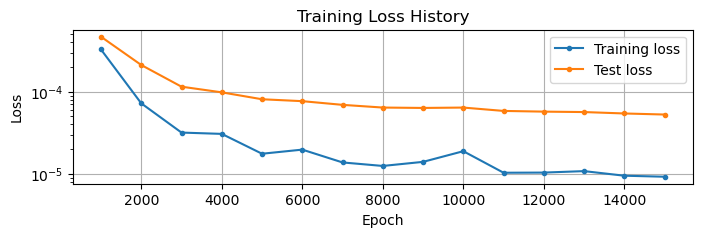

In [ ]:
# Loss history
model.plot_losshistory()

In [5893]:
# Plots the conserved quantity (the integral of u^2) over time
# Compares to the analytical quantity as well as to the 
# approximated quantity using Fourier coefficients
def plot_conservation(a, x0, N, dpi=100):
        
        k = torch.arange(model.N + 1)
        #d = k ** 0 + k ** 2
        
        # Weights used for "integration", i.e. summing of Fourier coefficients
        # Since we are using np.fft.rfft we need to weight all coefficients except the first by 2
        w = torch.concatenate((torch.tensor([1]), 2*torch.ones(N)))
        d = torch.sqrt(w)
        
        # Initial conditions        
        f = lambda x, a, t, x0: 3 * a**2 / np.cosh((a * (((x + x0) + 1 - a**2 * t) % 2 - 1)) / 2)**2
        
        
        # p_ = lambda x : (np.cosh(2*x) + 4) * np.tanh(x) ** 3 / np.cosh(x)**2
        # I_ = lambda a : 18 * a**5 * (p_(a/2) - p_(-a/2)) / 15
        
        # "Integrate" by summing Fourier coefficients
        integrate = lambda coeffs: model.L*(torch.linalg.norm(d * coeffs, axis=1)**2)
                    
        # Energy test boundary values
        analytical_integral_2 =  model.net.I2(a) 
        # analytical_integral_grad = model.net.gradI(a)
        
        t = torch.linspace(0, 1, 100, dtype=torch.float32)[:,None]        
        iv =  torch.tensor([[a, x0]], dtype=torch.float32)
        t_np = np.asarray(t, dtype=np.float32)
        x = np.linspace(-1, 1, 2*model.N+1)[None, :]
        
        # Calculate Fourier coefficients based on analytical solution
        analytical_sol = f(x, a, x0, t_np)
        analytical_coeffs = np.fft.rfft(analytical_sol) / (2*model.N+1) 
        
        # Make predicition
        pred = model.net(iv, t)[0,...]
        
        # Get and rescale predicted Fourier ceofficients 
        if not predict_fourier:
                #pred = torch.asarray(pred)
                pred_coeffs = torch.fft.rfft(pred) / (2*model.N+1) 
        else:
                pred_coeffs = torch.view_as_complex(pred.clone().detach().contiguous())
                pred = np.fft.irfft(pred_coeffs, n=2*model.N+1)
                pred_coeffs /= (2*model.N+1) 
                        
        #pred_integral = scipy.integrate.simpson(pred, x=np.linspace(-1, 1, 2*model.N+1), axis=-1)
        
        # Calculate the integral uf u^2 through Fourier coefficients
        pred_coeff_norm = integrate(pred_coeffs)
        analytic_coeff_norm = integrate(analytical_coeffs)
        
        
        t = t.detach()
        
        _, ax = plt.subplots(figsize=(8, 2), dpi=dpi)
        
        # Plot
        ax.set_title('$\int_{\mathbb{T}} u^2(x,t)dx$ - approximated via Fourier coeffs. - over time for $(a, x_0)$=' + f'({a}, {x0})')
        #ax.plot(t, torch.ones_like(t)*analytical_integral, alpha=0.5, linewidth=5, label='True')
        ax.plot(t, torch.ones_like(t)*(analytical_integral_2), alpha=0.5, linewidth=5, label='True')
        #ax.plot(t, pred_integral, '--', alpha=0.8, linewidth=3,  label='Pred Integral (via Simpson)')
        ax.plot(t, pred_coeff_norm.detach(), '--', alpha=0.8, linewidth=3,  label='Pred Coeff. Norm')
        ax.plot(t, analytic_coeff_norm, '--', alpha=0.8, linewidth=3,  label='Analytic Truncated Coeff. Norm')
        ax.legend()
        ax.grid(True)
        
        ax.set_xlabel("t")
        ax.set_ylabel("$\int_{\mathbb{T}} u^2(x, t)dx$")
        plt.show()

/var/folders/43/0xc7h8213cs2gpcym99hxdqm0000gn/T/ipykernel_47698/2797464116.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  integrate = lambda coeffs: model.L*(torch.linalg.norm(d * coeffs, axis=1)**2)


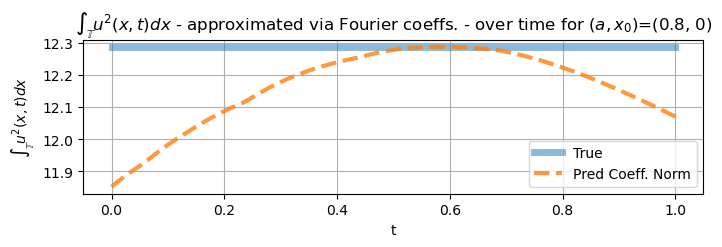

In [ ]:
# Plots the conserved quantity (the integral of u^2) over time
plot_conservation(a=0.8, x0=0, N=N)

In [5895]:
# Function for plotting predictions vs analytical solutions
def plot_predictions(a, x0, T): 

    # Paramaters
    a = np.array(a).astype(np.float32)
    x0 = np.array(x0).astype(np.float32)
    t = np.array([T]).astype(np.float32)

    
    # Analytical solution generator
    def analytical_solution(a, x0, t):
        x = np.linspace(-model.L/2, model.L/2, 2*model.N+1)[None, None, :]
        a, x0, t = a[:, None, None], x0[:, None, None], t[None, :, None]
        return model.f(x, a, t, x0), x[0,0,:]
    
    
    ground_truth, x = analytical_solution(a, x0, t)
    pred = model.predict(a, x0, t)
    
    if predict_fourier:
        pred = np.fft.irfft(torch.view_as_complex(pred.detach()), n=2*model.N+1)
    
    
    # Plot prediction vs. solution
    _, ax = plt.subplots(figsize=(10, 4), dpi=150)

    ax.set_title(f'Prediction of KdV Solution Using a DeepONet (for $t=${T})')
    O, o = x[0], ground_truth[0,0,0]
    
    

    #ax.plot(x, ground_truth[l,0,:][0:], label=label, alpha=0.3, linewidth=5, c=f'C{l}')
    #ax.plot(O, o, c='k', alpha=0.3, linewidth=5, label='Actual solution')
    #ax.plot(O, o, '--', c='grey', label='Predicted solution')

    for l in range(ground_truth.shape[0]):
        label = '({:.1f}, {:.1f})'.format(a[l], x0[l])
        
        ax.plot(x, ground_truth[l,0,:][0:], label=label, alpha=0.5, linewidth=5, c=f'C{l}')
        ax.plot(x, pred[l,0,:].tolist()[0:], '--', c=f'C{l}')

        ax.legend()
        ax.grid(True)
    ax.set_ylabel(f"u(x,{T})")
    ax.set_xlabel("x")
    plt.show()

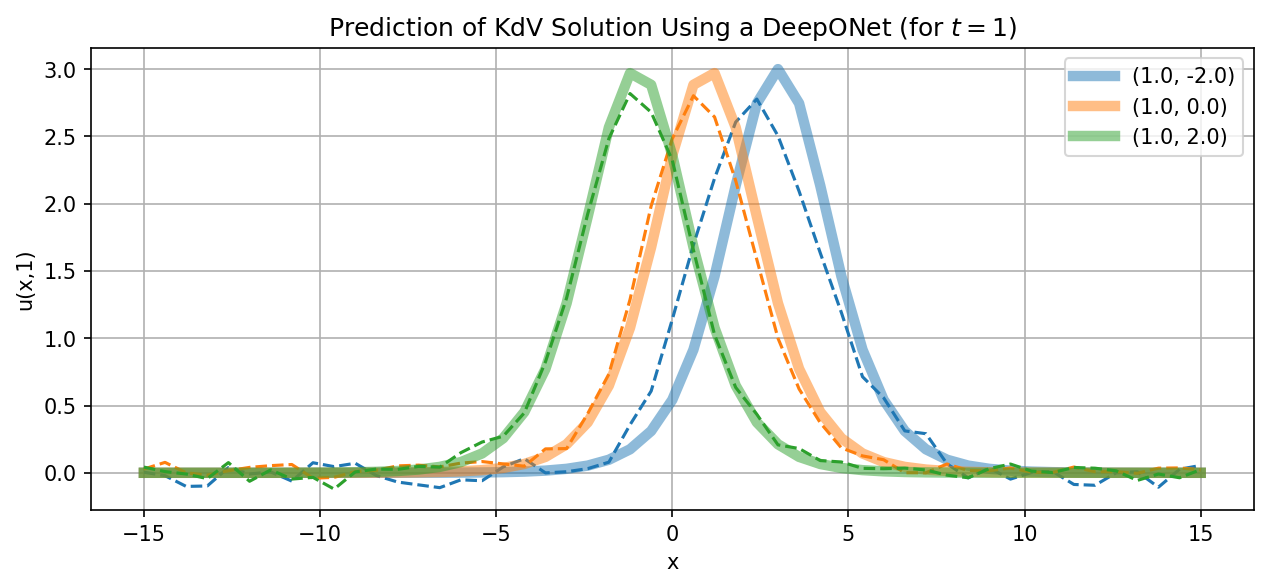

In [5900]:
# Plotting predictions vs analytical solutions
a = 1
plot_predictions(a=[a, a, a], x0=[-2, 0, 2], T=1)

In [5897]:
print(model.net.p)

Parameter containing:
tensor([1.], requires_grad=True)
